In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow
import time


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, recall_score


import random

from keras.preprocessing import image
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Lambda
from keras.optimizers import SGD, RMSprop
from keras import backend as K
import pandas as pd

from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
from keras import metrics
import keras_metrics

import numpy.random as rng
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
%matplotlib inline

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Décision sur le test set

Il y a 5005 classes différentes d'images parmi les 25 361 proposées, il y a 1647 classes avec plus ou moins que 3 images, 2932 avec plus que 2 images et 806 avec plus que 5. Nous allons donc sélectionner pour le test set une proportion de catégories venant de cette catégorie des images à plus de 3 images, pour pouvoir faire une comparaison aux dites classes (rapide réapprentissage sur les classes en question avec 2images et des exemples puis test pour savoir à laquelle des classes appartiennent les exemples.)

In [3]:
import time

train_data = pd.read_csv("dataset/train.csv")
time1 = time.time()
train_data.set_index('Id', inplace=True)
train_data.sort_index(inplace=True)

k=0
for sub_index in set(train_data.index):
    if len(set(train_data.loc[train_data.index==sub_index].Image))>=4:
         k+=1
print(k)

print((time.time()-time1)/60)

1079
0.1250813325246175


# Siamese Model

In [3]:
def W_init(shape,name=None):
    """Initialize weights as in paper"""
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)
#//TODO: figure out how to initialize layer biases in keras.
def b_init(shape,name=None):
    """Initialize bias as in paper"""
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

input_shape = (100, 200, 3)
left_input = Input(input_shape)
right_input = Input(input_shape)
#build convnet to use in each siamese 'leg'
convnet = Sequential()
convnet.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape,
                   kernel_initializer=W_init,kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(7,7),activation='relu',
                   kernel_regularizer=l2(2e-4),kernel_initializer=W_init,bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(Flatten())
convnet.add(Dense(4096,activation="sigmoid",kernel_regularizer=l2(1e-3),kernel_initializer=W_init,bias_initializer=b_init))

#call the convnet Sequential model on each of the input tensors so params will be shared
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

#layer to merge two encoded inputs with the l1 distance between them
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))

#call this layer on list of two input tensors.
L1_distance = L1_layer([encoded_l, encoded_r])
prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(L1_distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

optimizer = Adam(0.001)#Adam(0.001)#Adam(0.00006)
#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer)

siamese_net.count_params()

90344769

# Data Generator for Siamese Network

In [ ]:
class Siamese_Loader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self, path="./dataset/train.csv", data_subsets = ["fake", "real"]):
        self.data = {}
        #self.categories = {}
        self.info = {}
        
        data_train = pd.read_csv(path)
        self.dict_images = {}
        
        (real_data_train, fake_data_train), (real_data_test, fake_data_test),total_data_train, total_data_test = self.load_fake_real_data(data_train, test_percentage = 0.2)
        (real_data_train, fake_data_train) = (0,0)
        (real_data_test, fake_data_test) = (0,0)
        self.data['train']=total_data_train
        self.data['dev']=total_data_test
        self.data['real_train'] = real_data_train
        self.data['fake_train'] = fake_data_train
        self.data['real_test'] = real_data_test
        self.data['fake_test'] = fake_data_test
        
        # Training logs
        self.les_accuracy = []
        self.les_recall = []
        self.les_loss = []
        self.number_iteration = {}
#         self.dict_targets={}
#         self.dict_pairs={}
        #Initiate iterator for batch purpose
        self.iterator_batch = 0
        
                
    def load_fake_real_data(self, train_data, test_percentage=0.2):
        print("Loading...")
        train_data.set_index('Id', inplace=True)
        train_data.sort_index(inplace=True)
        fake_data_train = []
        real_data_train = []
        fake_data_test = []
        real_data_test = []
        #k=0
        s = 'train'
        for sub_index in set(train_data.index):
            if sub_index!="new_whale":
                #print(k)
                #print(sub_index)
                #k+=1
                images_same_class = list(set(train_data.loc[train_data.index==sub_index].Image))
                images_different_class = list(set(train_data.loc[train_data.index!=sub_index].Image))
                
                if (len(images_same_class) >= 2)and(len(images_same_class)<4) : #Condition for train
                    for i in range(len(images_same_class)):
                        self.dict_images[images_same_class[i]]=np.array([image.img_to_array(image.load_img("./dataset/"+s+"/"+images_same_class[i], target_size=(100, 200, 3)))])
                        for j in range(len(images_same_class)):
                            if i!=j :
                                real_data_train.append(np.array([images_same_class[i], images_same_class[j],1]))
                                random_image = np.random.randint(len(images_different_class))
                                self.dict_images[images_different_class[random_image]] = np.array([image.img_to_array(image.load_img("./dataset/"+s+"/"+images_different_class[random_image], target_size=(100, 200, 3)))])
                                fake_data_train.append(np.array([images_same_class[i], images_different_class[random_image],0]))
                            
                elif (len(images_same_class) >= 4) : #some_classes will be selected for testing
                   
                    for i in range(len(images_same_class)-2):
                        self.dict_images[images_same_class[i]]=np.array([image.img_to_array(image.load_img("./dataset/"+s+"/"+images_same_class[i], target_size=(100, 200, 3)))])
                        for j in range(len(images_same_class)-2):
                            real_data_train.append(np.array([images_same_class[i], images_same_class[j],1]))
                            random_image = np.random.randint(len(images_different_class))
                            self.dict_images[images_different_class[random_image]] = np.array([image.img_to_array(image.load_img("./dataset/"+s+"/"+images_different_class[random_image], target_size=(100, 200, 3)))])            
                            fake_data_train.append(np.array([images_same_class[i], images_different_class[random_image],0]))


                    for i in range(len(images_same_class)-2,len(images_same_class)):
                        self.dict_images[images_same_class[i]]=np.array([image.img_to_array(image.load_img("./dataset/"+s+"/"+images_same_class[i], target_size=(100, 200, 3)))])
                        for j in range(len(images_same_class)-2, len(images_same_class)):
                            real_data_test.append(np.array([images_same_class[i], images_same_class[j],1]))
                            random_image = np.random.randint(len(images_different_class))
                            self.dict_images[images_different_class[random_image]] = np.array([image.img_to_array(image.load_img("./dataset/"+s+"/"+images_different_class[random_image], target_size=(100, 200, 3)))])            
                            fake_data_test.append(np.array([images_same_class[i], images_different_class[random_image],0]))

        #Stacking the data
        real_data_train = np.vstack(real_data_train)
        fake_data_train = np.vstack(fake_data_train)
        
        real_data_test = np.vstack(real_data_test)
        fake_data_test = np.vstack(fake_data_test)
        
        #Shuffling
        train_data_shuffle = np.concatenate([fake_data_train, real_data_train])
        np.random.shuffle(train_data_shuffle)
        test_data_shuffle = np.concatenate([fake_data_test, real_data_test])
        np.random.shuffle(test_data_shuffle)
        
        print("Fake and Real data generated for siamese training.")
        return (real_data_train, fake_data_train), (real_data_test,fake_data_test), train_data_shuffle, test_data_shuffle

    def prepare_labels(self, y):
        values = np.array(y)
        label_encoder = LabelEncoder()
        integer_encoded = label_encoder.fit_transform(values)
        # print(integer_encoded)

        onehot_encoder = OneHotEncoder(sparse=False)
        integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
        onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
        # print(onehot_encoded)

        y = onehot_encoded
        # print(y.shape)
        return y, label_encoder
    def load_images_batch(self,batch_size, s='train'):
        """A ne pas runner ! Trop gourmand"""
        self.number_iteration[s] = len(self.data[s])/batch_size
        
        
        for i in range(int(self.number_iteration[s])):
            print(i)
            batch_data=self.data[s][i*batch_size:(i+1)*(batch_size)]
            image_left, image_right, targets = [],[],[]
            for fig in batch_data:
                image_left.append(self.dict_images[fig[0]])
                image_right.append(self.dict_images[fig[1]])
                targets.append(np.array([int(fig[2])]))
            image_left = np.vstack(image_left)
            image_right = np.vstack(image_right)

            #Finally we get the elements of the batch
            self.dict_targets[i] = np.vstack(targets)
            self.dict_pairs[i] = [image_left,image_right]

        

    def get_batch(self,batch_size,s="train"):
        """Create batch of n pairs, 1/3 same class, 2/3 different class"""
        
        
        
        
        #Condition to reset the loop of iteration
        if self.iterator_batch>=(len(self.data[s])/batch_size):
            self.iterator_batch = 0
            
        #For more readability
   
        i =self.iterator_batch
        #Let's load the batch
        batch_data=self.data[s][i*batch_size:(i+1)*(batch_size)]
        
        image_left, image_right, targets = [],[],[]
        for fig in batch_data:
            image_left.append(self.dict_images[fig[0]])
            image_right.append(self.dict_images[fig[1]])
            targets.append(np.array([int(fig[2])]))
        image_left = np.vstack(image_left)
        image_right = np.vstack(image_right)
        
        #Finally we get the elements of the batch
        targets = np.vstack(targets)
        pairs = [image_left,image_right]
#         targets = self.dict_targets[iterator_batch] 
#         pairs = self.dict_pairs[iterator_batch]
        
        #iteration step
        self.iterator_batch +=1
        
        return pairs, targets

    
    def generate(self, batch_size, s="train"):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = self.get_batch(batch_size,s)
            yield (pairs, targets)    
            
            
    def evaluate(self,model, batch_size) :
        
        s = "train"
        #Let's load the random batch
        list_indices = [np.random.randint(0,self.data['dev'].shape[0]) for i in range(batch_size)]
        batch_data=self.data['dev'][list_indices]
        
        image_left, image_right, targets = [],[],[]
        for fig in batch_data:
            image_left.append(self.dict_images[fig[0]])
            image_right.append(self.dict_images[fig[1]])
            targets.append(np.array([int(fig[2])]))
        image_left = np.vstack(image_left)
        image_right = np.vstack(image_right)
        
        #Finally we get the elements of the batch
        targets = np.vstack(targets)
        pairs = [image_left,image_right]
        
#         real_positive = np.argwhere(targets==[1])
#         print("Real_positive : {}".format(len(real_positive)))
#         self.targets = targets
#         self.model = model
#         #self.real_positive = real_positive
        
        
        y_predict = model.predict(pairs)
        
#         self.y_predict=y_predict
        my_recall = recall_score(targets,  np.where(y_predict>=0.5,1,0))#(targets[real_positive[:,0]], np.where(y_predict[real_positive[:,0]]>=0.5,1,0))
        my_accuracy = accuracy_score(targets,  np.where(y_predict>=0.5,1,0))
        
        # Saving train logs
        self.les_accuracy.append(my_accuracy)
        self.les_recall.append(my_recall)
        
        return my_recall, my_accuracy
        
    

    def make_oneshot_task(self,N,s="val",language=None):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        X=self.data[s]
        n_classes, n_examples, w, h = X.shape
        indices = rng.randint(0,n_examples,size=(N,))
        if language is not None:
            low, high = self.categories[s][language]
            if N > high - low:
                raise ValueError("This language ({}) has less than {} letters".format(language, N))
            categories = rng.choice(range(low,high),size=(N,),replace=False)
            
        else:#if no language specified just pick a bunch of random letters
            categories = rng.choice(range(n_classes),size=(N,),replace=False)            
        true_category = categories[0]
        ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
        test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
        support_set = X[categories,indices,:,:]
        support_set[0,:,:] = X[true_category,ex2]
        support_set = support_set.reshape(N, w, h,1)
        targets = np.zeros((N,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image,support_set]

        return pairs, targets
    
    def test_oneshot(self,model,N,k,s="val",verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        if verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ...".format(k,N))
        for i in range(k):
            inputs, targets = self.make_oneshot_task(N,s)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy".format(percent_correct,N))
        return percent_correct
    
    def train(self, model, epochs, verbosity):
        model.fit_generator(self.generate(batch_size),use_multiprocessing=True
                            
                             )
    
    
#Instantiate the class
time1 = time.time()
loader = Siamese_Loader()
print((time.time()-time1)/60)

Loading...
Fake and Real data generated for siamese training.
3.7108000040054323


# Training loop

In [4]:
loader.data['train'].shape

(232272, 3)

In [ ]:
len(loader.dict_images)

25266

In [4]:
#Training loop
print("Starting the training loop...")
evaluate_every = 20 # interval for evaluating on one-shot tasks
loss_every=5 # interval for printing loss (iterations)
batch_size = 64
n_iter = 30000
N_way = 20 # how many classes for testing one-shot tasks>
n_val = 250 #how mahy one-shot tasks to validate on?
best = -1
weights_path = os.path.join("weights", "weights")
print("Training...")
for i in range(1, n_iter):
    (inputs,targets)=loader.get_batch(batch_size)
    loss=siamese_net.train_on_batch(inputs,targets)
    # Save loss
    loader.les_loss.append(loss)
    
    #print(loss)
    if i % evaluate_every == 0:
        print("Evaluating...")
        val_recall, val_accuracy = loader.evaluate(siamese_net,200)
        print("Recall : {}, Accuracy : {}".format(val_recall,val_accuracy))
        
        if val_accuracy >= best:
            print("Saving weights...")
            siamese_net.save(weights_path)
            best=val_accuracy
        
    if len(loader.les_accuracy) > 15 and loader.les_accuracy[-1] <= min(loader.les_accuracy[-10:]):
        print("Appears to have stop learning. Early stopping")
        break

    if i % loss_every == 0:
        print("iteration {}, training loss: {:.2f},".format(i,loss))

Starting the training loop...
Training...
Instructions for updating:
Use tf.cast instead.
iteration 5, training loss: 7.80,
iteration 10, training loss: 5.47,
iteration 15, training loss: 3.83,
Evaluating...
Recall : 0.9902912621359223, Accuracy : 0.53
Saving weights...
iteration 20, training loss: 2.93,
iteration 25, training loss: 2.37,
iteration 30, training loss: 1.99,
iteration 35, training loss: 1.77,
Evaluating...
Recall : 0.8021978021978022, Accuracy : 0.62
Saving weights...
iteration 40, training loss: 1.56,
iteration 45, training loss: 1.42,
iteration 50, training loss: 1.35,
iteration 55, training loss: 1.30,
Evaluating...
Recall : 0.7555555555555555, Accuracy : 0.695
Saving weights...
iteration 60, training loss: 1.20,
iteration 65, training loss: 1.19,
iteration 70, training loss: 1.14,
iteration 75, training loss: 1.14,
Evaluating...
Recall : 0.8155339805825242, Accuracy : 0.74
Saving weights...
iteration 80, training loss: 1.13,
iteration 85, training loss: 1.15,
iterati

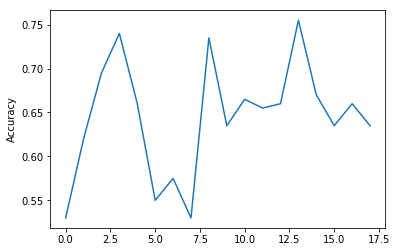

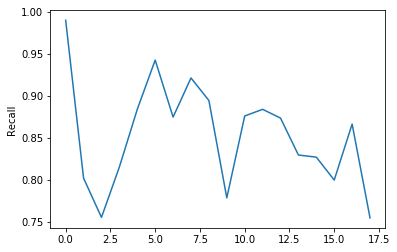

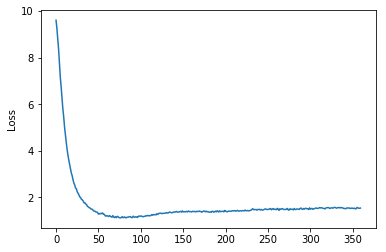

In [5]:
def disp_train():
    
    plt.plot(loader.les_accuracy)
    plt.ylabel("Accuracy")
    plt.savefig("figure/accuracy1.png", dpi = 1200)
    plt.show()
    
    plt.plot(loader.les_recall)
    plt.ylabel("Recall")
    plt.savefig("figure/recall1.png", dpi = 1200)
    plt.show()
    
    plt.plot(loader.les_loss)
    plt.ylabel("Loss")
    plt.savefig("figure/loss1.png", dpi = 1200)
    plt.show()
    
disp_train()

In [4]:
#Training loop
print("Starting the training loop...")
evaluate_every = 50 # interval for evaluating on one-shot tasks
loss_every=5 # interval for printing loss (iterations)
batch_size = 64
n_iter = 30000
N_way = 20 # how many classes for testing one-shot tasks>
n_val = 250 #how mahy one-shot tasks to validate on?
best = -1
weights_path = os.path.join("weights", "weights")
print("Training...")
for i in range(1, n_iter):
    (inputs,targets)=loader.get_batch(batch_size)
    loss=siamese_net.train_on_batch(inputs,targets)
    # Save loss
    loader.les_loss.append(loss)
    
    #print(loss)
    if i % evaluate_every == 0:
        print("Evaluating...")
        val_recall, val_accuracy = loader.evaluate(siamese_net,200)
        print("Recall : {}, Accuracy : {}".format(val_recall,val_accuracy))
        
        if val_accuracy >= best:
            print("Saving weights...")
            siamese_net.save(weights_path)
            best=val_accuracy
        
    if len(loader.les_accuracy) > 15 and loader.les_accuracy[-1] <= min(loader.les_accuracy[-10:]):
        print("Appears to have stop learning. Early stopping")
        #break

    if i % loss_every == 0:
        print("iteration {}, training loss: {:.2f},".format(i,loss))

Starting the training loop...
Training...
Instructions for updating:
Use tf.cast instead.
iteration 5, training loss: 7.52,
iteration 10, training loss: 5.01,
iteration 15, training loss: 3.56,
iteration 20, training loss: 2.69,
iteration 25, training loss: 2.17,
iteration 30, training loss: 1.84,
iteration 35, training loss: 1.59,
iteration 40, training loss: 1.46,
iteration 45, training loss: 1.28,
Evaluating...
Recall : 0.8666666666666667, Accuracy : 0.595
Saving weights...
iteration 50, training loss: 1.20,
iteration 55, training loss: 1.18,
iteration 60, training loss: 1.15,
iteration 65, training loss: 1.14,
iteration 70, training loss: 1.09,
iteration 75, training loss: 1.10,
iteration 80, training loss: 1.10,
iteration 85, training loss: 1.08,
iteration 90, training loss: 1.21,
iteration 95, training loss: 1.17,
Evaluating...
Recall : 0.9222222222222223, Accuracy : 0.64
Saving weights...
iteration 100, training loss: 1.26,
iteration 105, training loss: 1.30,
iteration 110, trai

KeyboardInterrupt: 

In [ ]:
#Training loop
print("Starting the training loop...")
evaluate_every = 30 # interval for evaluating on one-shot tasks
loss_every=5 # interval for printing loss (iterations)
batch_size = 64
n_iter = 30000
N_way = 20 # how many classes for testing one-shot tasks>
n_val = 250 #how mahy one-shot tasks to validate on?
best = -1
weights_path = os.path.join("weights", "weights")
print("Training...")
for i in range(1, n_iter):
    (inputs,targets)=loader.get_batch(batch_size)
    loss=siamese_net.train_on_batch(inputs,targets)
    # Save loss
    loader.les_loss.append(loss)
    
    #print(loss)
    if i % evaluate_every == 0:
        print("Evaluating...")
        val_recall, val_accuracy = loader.evaluate(siamese_net,200)
        print("Recall : {}, Accuracy : {}".format(val_recall,val_accuracy))
        
        if val_accuracy >= best:
            print("Saving weights...")
            siamese_net.save(weights_path)
            best=val_accuracy
        
    if len(loader.les_accuracy) > 15 and loader.les_accuracy[-1] <= min(loader.les_accuracy[-10:]):
        print("Appears to have stop learning. Early stopping")
        #break

    if i % loss_every == 0:
        print("iteration {}, training loss: {:.2f},".format(i,loss))

Starting the training loop...
Training...
Instructions for updating:
Use tf.cast instead.
iteration 5, training loss: 7.69,
iteration 10, training loss: 5.33,
iteration 15, training loss: 3.81,
iteration 20, training loss: 2.92,
iteration 25, training loss: 2.46,
Evaluating...
Recall : 0.9528301886792453, Accuracy : 0.635
Saving weights...
iteration 30, training loss: 2.13,
iteration 35, training loss: 1.88,
iteration 40, training loss: 1.77,
iteration 45, training loss: 1.64,


In [40]:
type(np.where(loader.y_predict[loader.real_positive[:,0]]>=0.5,1,0)[0,0])

numpy.int32

In [51]:
from sklearn.metrics import accuracy_score
y= np.array([1,0,1,0,1,0,1,0,1])
y_pred = np.array([0,0,0,0,0,0,0,0,0])
accuracy_score(y, y_pred)

0.4444444444444444

In [48]:
metrics.binary_accuracy(loader.targets,np.where(loader.y_predict>=0.5,1,0)).

TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got 'Mean_4:0'

In [ ]:
#Training loop
print("!")
evaluate_every = 1 # interval for evaluating on one-shot tasks
loss_every=50 # interval for printing loss (iterations)
batch_size = 32
n_iter = 90000
N_way = 20 # how many classes for testing one-shot tasks>
n_val = 250 #how mahy one-shot tasks to validate on?
best = -1
weights_path = os.path.join(PATH, "weights")
print("training")
for i in range(1, n_iter):
    (inputs,targets)=loader.get_batch(batch_size)
    loss=siamese_net.train_on_batch(inputs,targets)
    print(loss)
    if i % evaluate_every == 0:
        print("evaluating")
        #val_acc = loader.test_oneshot(siamese_net,N_way,n_val,verbose=True)
        if val_acc >= best:
            print("saving")
            siamese_net.save(weights_path)
            best=val_acc

    if i % loss_every == 0:
        print("iteration {}, training loss: {:.2f},".format(i,loss))